In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D
import multiprocessing

# custom functions
from functions import *

2024-11-11 23:12:58.960875: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731363178.980261   36503 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731363178.985830   36503 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-11 23:12:59.004783: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/michael/.pyenv/versions/funnypress-data-study/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: 

In [2]:
df = pd.read_csv('../data/clean/dataset.csv').fillna('')

In [3]:
df

,name,url,title,lemmes,funny
0,le_monde,https://www.lemonde.fr/disparitions/article/20...,"Simon Fieschi, grièvement blessé pendant l’att...",simon fieschi grievement blesser attentat cont...,0
1,le_monde,https://www.lemonde.fr/idees/article/2024/10/1...,« Il faut expliquer la différence entre les ef...,falloir expliquer difference effet concret imm...,0
2,le_monde,https://www.lemonde.fr/economie/article/2024/1...,Le périphérique a désormais son outil évaluate...,peripherique outil evaluateur kilometre heure,0
3,le_monde,https://www.lemonde.fr/economie/article/2024/1...,"En Occitanie, les agriculteurs mécontents mult...",occitanie agriculteur mecontent multiplier act...,0
4,le_monde,https://www.lemonde.fr/les-decodeurs/article/2...,Présidentielle américaine 2024 : comment Donal...,presidentielle americain donald trump instrume...,0
...,...,...,...,...,...
102080,ouest_france,https://www.ouest-france.fr/pays-de-la-loire/t...,Le défi Foyers à alimentation positive d’Erd...,defi foyers alimentation positif erdre gesvre ...,0
102081,ouest_france,https://www.ouest-france.fr/sport/football/red...,"Football. Le propriétaire du Red Star, 777 Pa...",football proprietaire red star partners failli...,0
102082,ouest_france,https://www.ouest-france.fr/normandie/lisieux-...,"Plus d’un an après les émeutes à Lisieux, l...",an apres emeute lisieux poste police municipal...,0
102083,ouest_france,https://www.ouest-france.fr/bretagne/finistere...,Le Sud-Finistère célèbre la culture urbaine...,sud finistere celebre culture urbain etat,0


In [4]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 24 # adapt to length of sentences
sentences = df['lemmes'].to_list()
sentences = [simple_preprocess(text) for text in sentences]

In [5]:
w2v_model = Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=314,
                                                # workers=1)
                                               workers=multiprocessing.cpu_count())

In [6]:
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)

(76791405, 78204400)

In [7]:
model_vectors = w2v_model.wv

In [8]:
w2v_words = model_vectors.index_to_key

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1

In [10]:
# weights matrix
print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (47037, 300)


In [11]:
# Model creation

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

/home/michael/.pyenv/versions/funnypress-data-study/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1731363307.701109   36503 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1730 MB memory:  -> device: 0, name: NVIDIA GeForce MX150, pci bus id: 0000:01:00.0, compute capability: 6.1


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 24, 300)        │    14,111,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 300)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,111,100 (53.83 MB)

 Trainable params: 14,111,100 (53.83 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

  48/3191 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step    

/home/michael/.pyenv/versions/funnypress-data-study/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1']. Received: the structure of inputs=*
  warnings.warn(
I0000 00:00:1731363308.602507   37620 service.cc:148] XLA service 0x7f95e0003ab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731363308.602528   37620 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce MX150, Compute Capability 6.1
I0000 00:00:1731363308.609308   37620 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-11 23:15:08.623705: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or 

3191/3191 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


(102085, 300)

<Figure size 800x600 with 0 Axes>

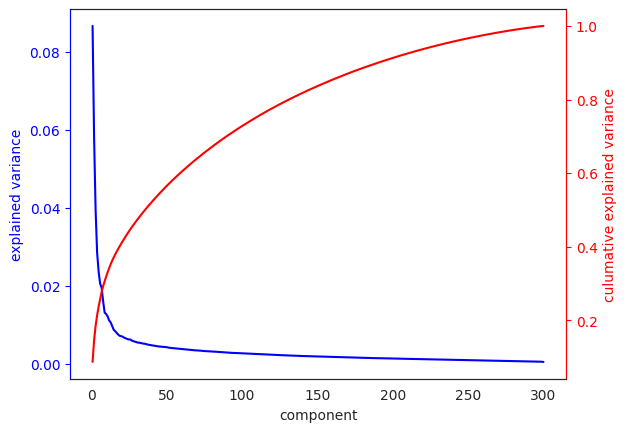

In [13]:
pca_graph(embeddings)

In [14]:
y = df.funny

In [15]:
mapper = umap.UMAP(n_components=2, n_jobs=-1, verbose=1).fit(embeddings)    

UMAP( verbose=1)
Mon Nov 11 23:15:14 2024 Construct fuzzy simplicial set
Mon Nov 11 23:15:14 2024 Finding Nearest Neighbors
Mon Nov 11 23:15:14 2024 Building RP forest with 21 trees
Mon Nov 11 23:15:23 2024 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	 5  /  17
	 6  /  17
	Stopping threshold met -- exiting after 6 iterations
Mon Nov 11 23:15:42 2024 Finished Nearest Neighbor Search
Mon Nov 11 23:15:46 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Nov 11 23:16:35 2024 Finished embedding


<Axes: >

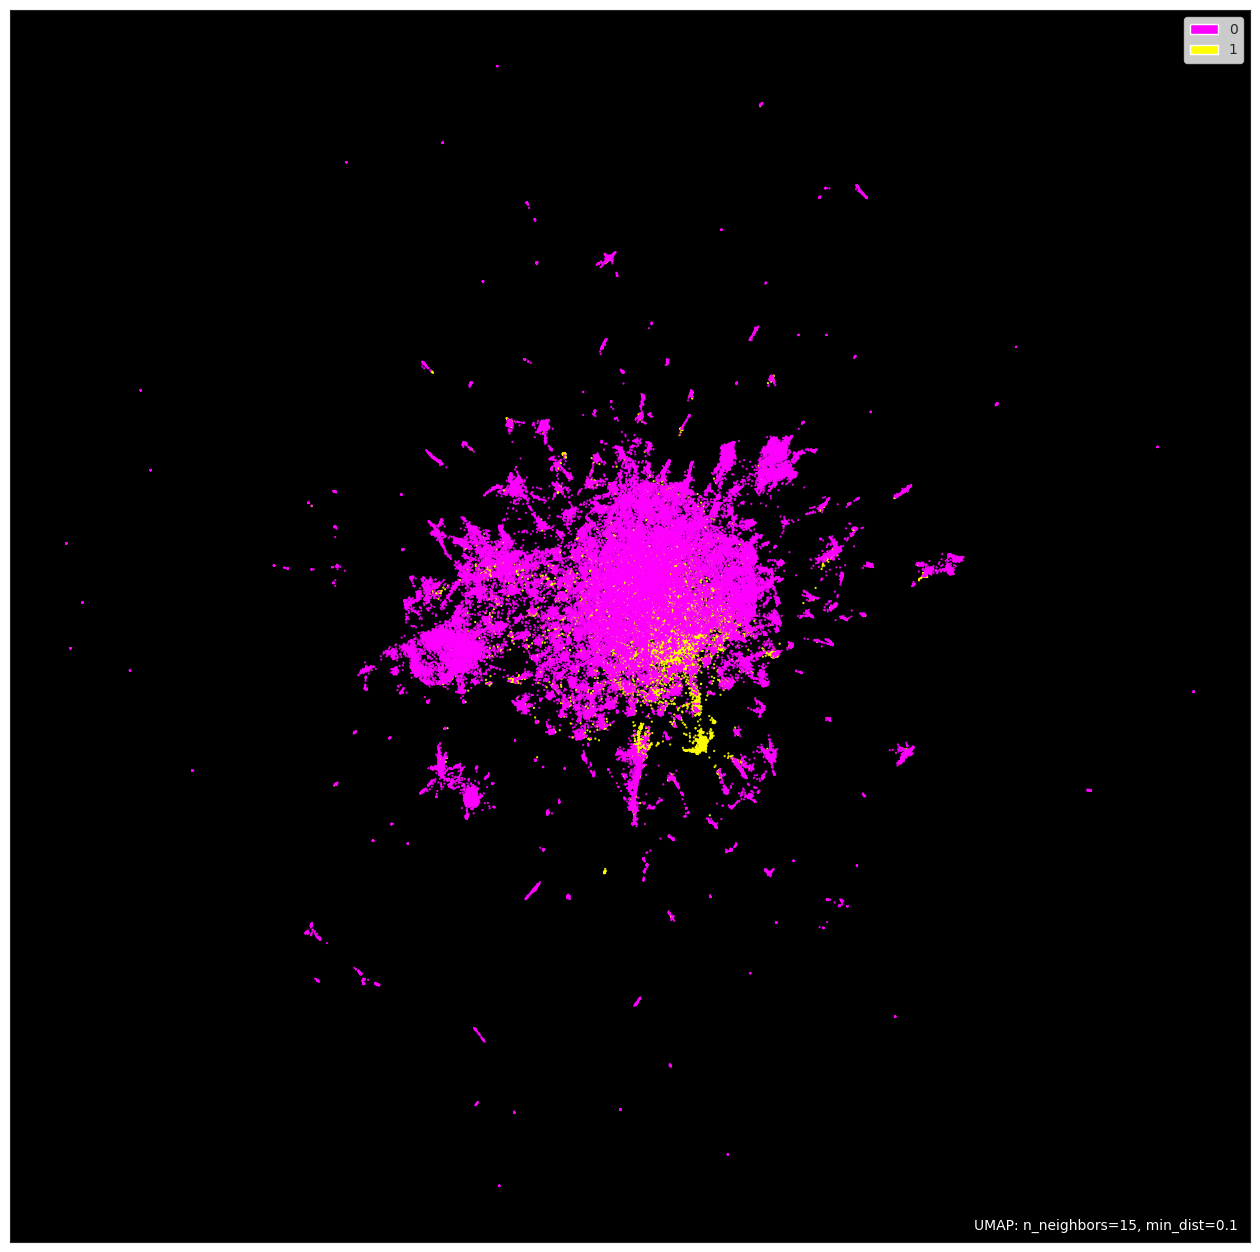

In [16]:
umap.plot.points(mapper, labels=y, background='black', color_key_cmap='spring', width=1600, height=1600)